# AE-410 GPS (Assignment-1 Acquisition)
Rollno. 20D170022
Name - Lyric Khare

In [1]:
# Shri Ganeshaya Namah
# @author.lyrickhare

## Some important Relations / Properties
- $C_i(\eta-\tau)$ is the PRN code (similar to a vector/array with 1023 dimensions/elements) for $i-th$ satellite, delayed by $\tau$ chips
- $C_i(\eta) = C_i(\eta+1023)$ i.e. PRN codes are periodic with period = 1023 chips = 1 millisecond
- $\frac{C_i(\eta)\oplus C_j(\eta-\tau)}{1023} = 1$ {iff $i=j$ and $\tau = 0$, = 0 otherwise}
- $\oplus$ in the above point denotes correlation, i.e. element wise multiplication:

    - $C_i(\eta)\oplus C_j(\eta-\tau) = \sum_{r = 0}^{r = 1022}  C_i(\eta)[r]\cdot C_j(\eta-\tau)[r] $
    - $C_i(\eta)[r]$ is a scalar value having 0 or 1 value

## Theory for serial search
- we know the signal received at the antenna is:


$s(t) = \sqrt{2P}D(t-\tau)C_j(t-\tau)cos((w_L+w_D)t+\theta)$
where : 
    - P is power
    - $\tau$ is delay ($\tau = \tau_{int} + \tau_{frac}$)
    - $w_L$ is L-5 band frequency and $w_D$ is doppler frequency

- After RF front-end processing we get:

$ I = \sqrt{2P_1}D(t-\tau)C_j(t-\tau)cos( (w_D)t+\theta)$


$ Q = \sqrt{2P_1}D(t-\tau)C_j(t-\tau)sin( (w_D)t+\theta)$

where:
    - I is Inphase samples
    - Q is Quadrature samples

**Note** : slight abuse of notation is used as we defined C for discrete values while here we are considering it as continous, but this discrepancy will be resolved in program as we have input data as discrete samples

#### Now,
for serial search we need to get 3 parameters 

- $i$ the satellite number
- $\tau_{frac} \in [0,1022]$
- $w_D \in [-10k Hz : 500 Hz : 10k Hz]$

#### Steps

- Firstly, we will rewrite signal as $S = I + Qj = \sqrt{2P_1}D(t-\tau)C(t-\tau)e^{jw_dt}$

- Then, we will multiply $S$ by $C(t-\hat\tau)e^{-j\hat w_dt}$

- We will get:

$ Corr = \sqrt{2P_1}D(t-\tau)C_j(t-\tau)\oplus C_i(t-\hat\tau)e^{j(w_d-\hat w_d)t}$

it will attain it's maximum when :

$w_d-\hat w_d = 0$


$\tau = \hat\tau$

$i = j = $ satellite number of incoming signal

## Serial Search
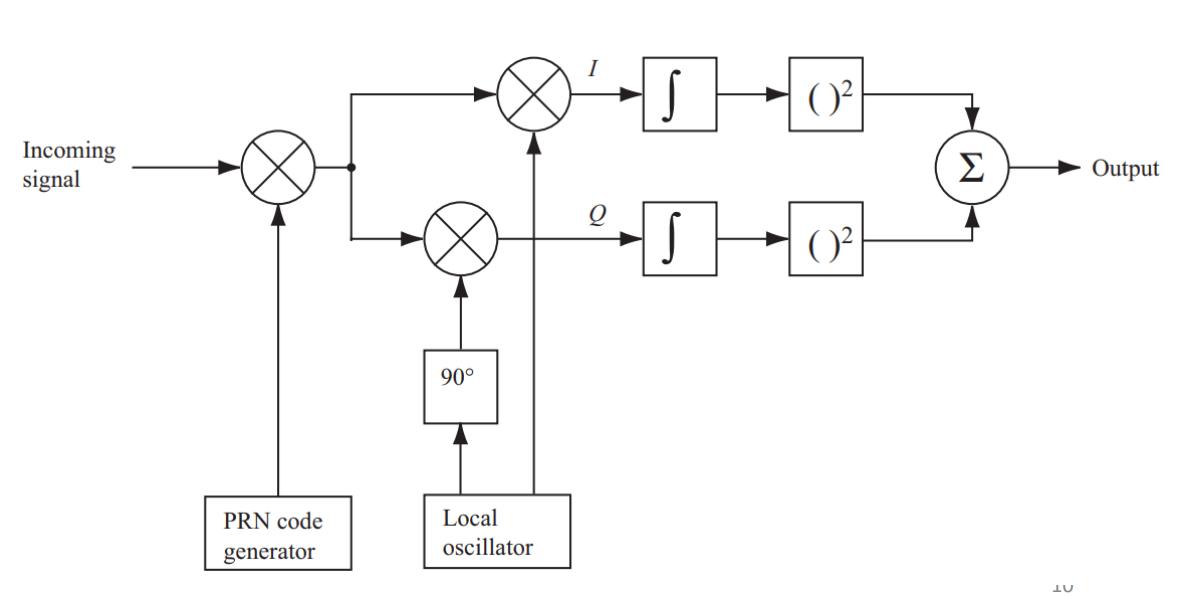

## Parallel code phase search
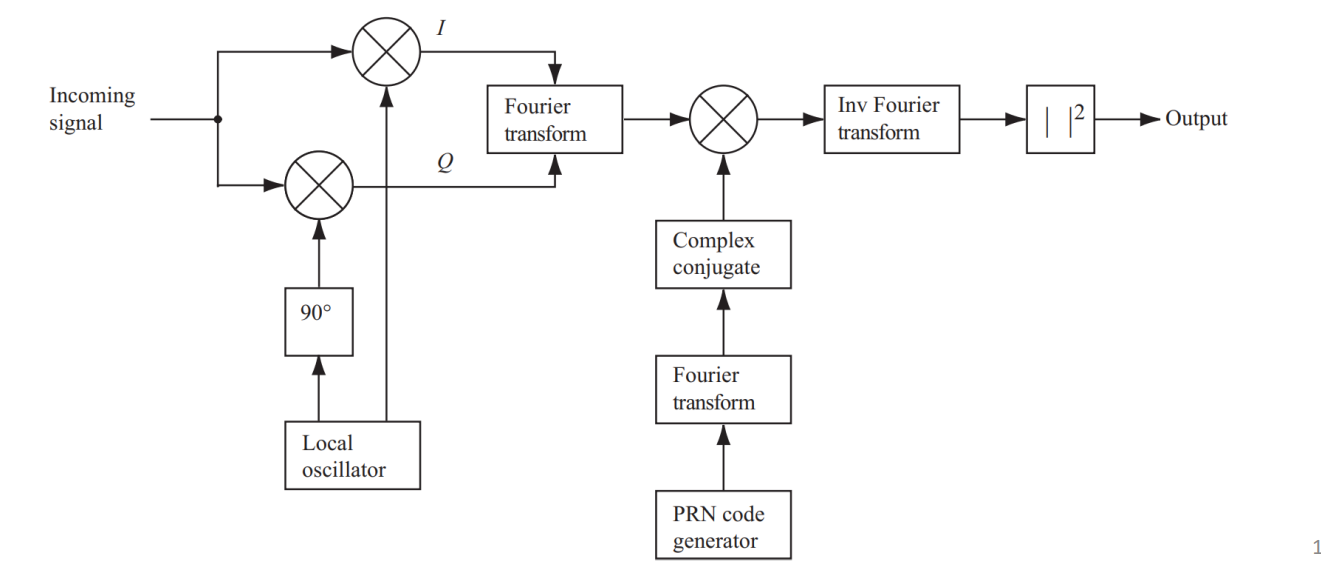

## Data set utilized
RTL_SDR
The data set recorded with a RTL_SDR. This collection includes the GPS L1 band with 2.048MHz bandwidth and 2.048MSPS@8bit I/Q sampling rate. The data was collected on Sep 10, 2017 also in Oegstgeest, Netherlands. The acquired signals belong to the GPS L1 band (PRN 5, 13, 15, 20, 28, 30).

link for the dataset : https://sdr.ion.org/RTL_SDR/RTLSDR_Bands-L1.uint8

# Implementation

In [2]:
# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy
import numba as nb

In [3]:
# constants
n = 2 # times sampling frequency
wds = np.linspace(-10000,10000,41)
t = np.linspace(0,1,1023*n)*1e-3
# GPS PRN Extraction
codesFile = scipy.io.loadmat("codes_L1CA.mat")
codes = np.array(codesFile['codes_L1CA'])

In [4]:
# reading datafile having sampling frequency 1*1.023 MHz
raw_data = np.fromfile("RTLSDR_Bands-L1.uint8", dtype=np.uint8)

In [5]:
# took 2*2*1023 data points because we need 2*1023 data points for each I and Q
samples = samples = raw_data[0:4092]

In [6]:
# stadard format of sdr data defined on the website
I = samples[0::2]
Q = samples[1::2]

In [7]:
# converting to float to have easier operations
I= I.astype(np.float64)
Q= Q.astype(np.float64)

In [8]:
# reducing it to ensure the sign bits are intact
I = I - 128
Q = Q - 128

In [9]:
# normalizing the chips
I = I/128
Q = Q/128

In [10]:
# Serial search

def modPRN(PRN,n,tau):
    """
    function to get modified PRN for some sampling frequency & delay
    Inputs: 
        - PRN is the PRN code for single satellite with 1023 length
        - n = SamplingFrequency/1.023e6 
    Output:
        - PRN code for 1 millisecond with length = 1023*n
        - This PRN code is delayed by tau chips
    """

    # return np.roll(np.repeat(PRN,n),-tau)
    return np.repeat(np.roll(PRN,-tau),n)


def serialSearch(I, Q, knownPRNs, Fs, wds=wds):
    """ 
    An algo that serially finds correlation of input I and Q with all the 
    PRN-ID (satellite number), wds and delays
    """
    rcvdSignal = np.array(I+Q*1j)
    n = int(Fs/1.023e6)
    t = np.linspace(0,1,n*1023)*1e-3
    totalSatellites = knownPRNs.shape[1]
    corr = np.zeros((totalSatellites,len(wds),1023))
    for x in range(0,totalSatellites):
        for y in range(0,len(wds)):
            for z in range(0,1023):
                generatedSignal = modPRN(knownPRNs[:,x],n,z)*np.array(np.exp(-1j*wds[y]*t*2*np.pi))
                corr[x,y,z] = np.abs(np.sum(generatedSignal*rcvdSignal))
    return corr

In [13]:
%%time
corrSerial = serialSearch(I,Q,codes,2*1.023e6)

CPU times: total: 45 s
Wall time: 3min 53s


In [14]:
corrSerial = corrSerial

Text(0.5, 0, 'flattened array with [satNum][wd][tau]')

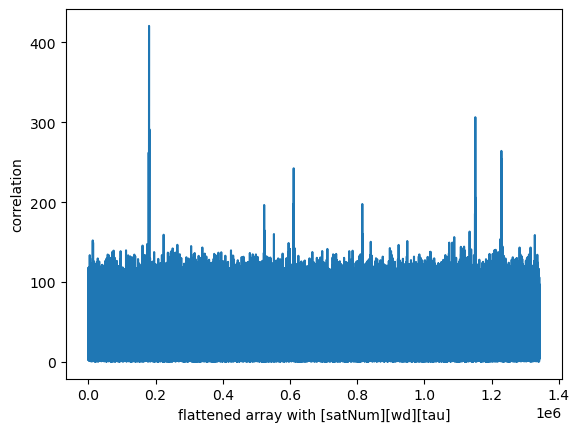

In [15]:
plt.plot(corrSerial.flatten())
plt.ylabel("correlation")
plt.xlabel("flattened array with [satNum][wd][tau]")

In the above figure it is clearly visible that there are some peaks, if we want to extract the indices of those peaks, we can set some threshold
eg. threshold = 180

In [16]:
peaksIndices = np.argwhere(corrSerial>180)

In [17]:
peaksIndices

array([[  4,  11, 330],
       [  4,  12, 330],
       [  4,  13, 330],
       [ 12,  19, 325],
       [ 14,  22, 173],
       [ 14,  23, 173],
       [ 19,  17, 858],
       [ 27,  17, 729],
       [ 27,  18, 729],
       [ 27,  19, 729],
       [ 29,  12, 525],
       [ 29,  13, 525]], dtype=int64)

It is clear that we are able to extract the PRN-IDs , since the index starts from 0 so instead of 5, 13, 15 ..... these are 4, 12, 14 .....

## Parallel code phase search

For this we will be leveraging numba, which is a **just in time compiler" for python, it can handle parallel computations easily

### Note:
The following code will not work if you don't have cuda setup with numba

In [18]:
# function generating a matrix having all the delayed PRN with repetitions and each with wds varying from -10k to 10k with 500 step
def genA():
    A = [[np.repeat(np.roll(codes[:,satNum],-tau),n) for tau in range(0,1023)]for satNum in range(0,32)]
    return A

In [19]:
a = np.array(genA())

In [20]:
@nb.jit(nopython=True,target_backend ='cuda')
def parallelSearch(I,Q,codes,wds,n,a):

    # reshaping the array for smooth operations
    I = I.reshape(1023*n)
    Q = Q.reshape(1023*n)

    # empty arrays for correlations
    corrR=np.empty((32,41,1023))
    corrI=np.empty((32,41,1023))

    #iterating in wds
    for y in range(0,41):
        amodR = a*np.cos(2*np.pi*wds[y]*t)
        amodI = a*np.sin(-2*np.pi*wds[y]*t)

        # using basics of complex multiplication because numba doesn't support complex multiplication directly
        for x in range(0,32):
            corrR[x,y] = np.dot(amodR[x],I)-np.dot(amodI[x],Q)
            corrI[x,y] = np.dot(amodR[x],Q)+np.dot(amodI[x],I)

    return corrR,corrI

In [21]:
%%time
corrR,corrI = parallelSearch(I,Q,codes,wds,n,a)

CPU times: total: 8.86 s
Wall time: 38.2 s


In [22]:
corrParr = np.sqrt(corrR**2+corrI**2)

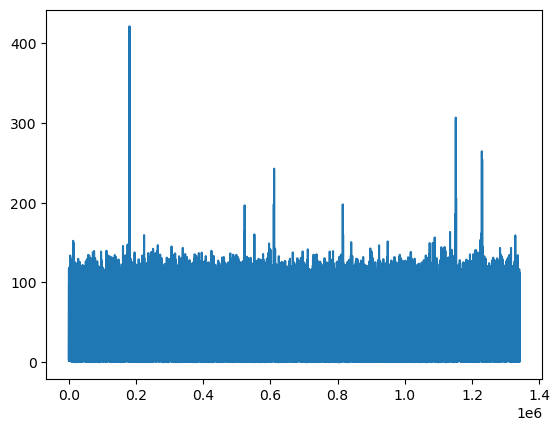

In [23]:
plt.plot(corrParr.flatten())

We can clearly see that we have gotten the same plot, we can again set a similar threshold and can get the required params

In [24]:
peaksIndicesParr = np.argwhere(corrParr>180)

In [25]:
peaksIndicesParr

array([[  4,  11, 330],
       [  4,  12, 330],
       [  4,  13, 330],
       [ 12,  19, 325],
       [ 14,  22, 173],
       [ 14,  23, 173],
       [ 19,  17, 858],
       [ 27,  17, 729],
       [ 27,  18, 729],
       [ 27,  19, 729],
       [ 29,  12, 525],
       [ 29,  13, 525]], dtype=int64)

It can also be noted that the parallel code phase search is much faster than serial search by 10x

### Note:
for delay, I have used it as the time before which satellite has emitted this data, so if we compare, it can be (1023-delay) which we take positive many times